[View in Colaboratory](https://colab.research.google.com/github/lucaspalomeque/diario_lucas/blob/master/Estrategia_Momentum.ipynb)

##Estrategia Momentum 

Que es: Tomas muchos promedios ponderados de promedios en diferentes series de tiempo. Una vez que tenes esa info en cada momento los rankeas. Luego de tener un ranking de las medias moviles, aplicamos la funcion del coeficiente de Spearman (hay varias que podrias probar para ver cual da mejor, te adjunto un link abajo) y el score que vas teniendo va a darte una nocion de si la tendencia es a la suba o a la baja. 


In [0]:
#Paquetes a importar en Python. 
from  statsmodels import regression
import statsmodels.api as sm
import scipy.stats as stats
import scipy.spatial.distance as distance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

!pip install -q xlrd


In [0]:
# Modulos para usar Drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [14]:
#abrir y guardar archivos del exchange para trabajar. Vas a tener q descargarlos a tu compu. No se como cargarlo desde el drive. 
from google.colab import files
uploaded = files.upload()

Saving REPBTC_binance.xlsx to REPBTC_binance.xlsx


In [15]:
#checkiar que los archivos esten ok
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))


User uploaded file "REPBTC_binance.xlsx" with length 23995 bytes


In [0]:
#apertura de excels con informacion, esto tiene los
#tickers, ellos deberian armarselo con los trades. 
df=pd.read_excel('REPBTC_binance.xlsx')

En este caso fijamos el index como el tiempo que paso. El index no deberia ser por tiempo sino que por volumen transaccionado : 1BTC, 2 BTC, 3 BTC, etc, habria que jugar y ver cual es la mejor cantidad. Daria un dataset mas preciso

In [0]:
#estandirazar el tiempo sacando la T y Z del scrap y ponerlo como index
df['openTime'] = df['openTime'].map(lambda x: x.replace('T', ' ').rstrip("Z"))
df["openTime"] = pd.to_datetime(df["openTime"])
df.set_index('openTime',inplace=True)

# Calculo de la media movil general, no es tan necesario
df['mu'] = [df['close'][:i].mean() for i in range(len(df))]

Con la informacion que ya se chupo creamos el promedio movil en cada punto. En este caso le puse que tome las medias moviles del precio close de 1 a 10 minutos para atras con con 10 muestras. Eso se podria mejorar. 

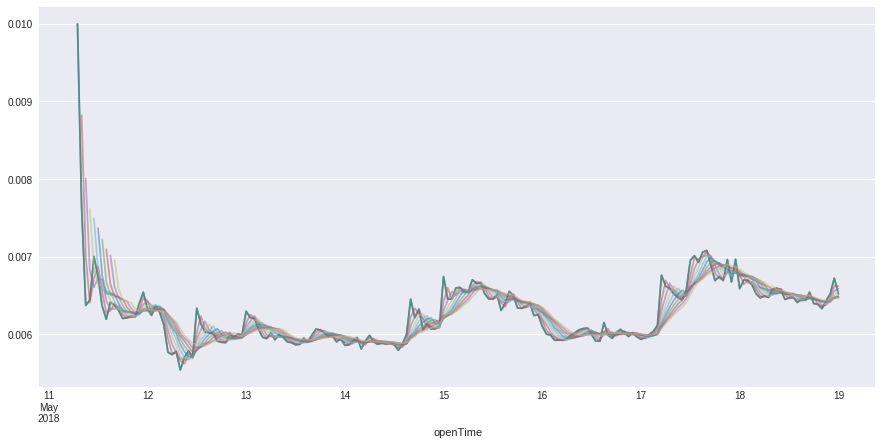

In [19]:
#rolling_means ribbon, crear el diccionario.
df['close'].plot(alpha = 1)
rolling_means = {}

# calcular la media movil en diferentes rangos con el precio close 
for i in np.linspace(1, 10, 10):
    X = df['close'].rolling(window=int(i),center=False).mean()
    rolling_means[i] = X
    X.plot(figsize=(15,7), alpha = 0.55)
    
rolling_means = pd.DataFrame(rolling_means).dropna()
plt.show()
plt.savefig("price_ribbon.png")


In [26]:
#ejemplo de rolling mean
rolling_means.head(10)

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
openTime,,,,,,,,,,
2018-05-11 16:00:00,0.006369,0.006391,0.006324,0.006334,0.006415,0.006512,0.006502,0.006485,0.006614,0.006952
2018-05-11 17:00:00,0.006305,0.006337,0.006362,0.006319,0.006328,0.006396,0.006483,0.006477,0.006465,0.006583
2018-05-11 18:00:00,0.006201,0.006253,0.006292,0.006322,0.006296,0.006307,0.006368,0.006447,0.006447,0.006439
2018-05-11 19:00:00,0.006211,0.006206,0.006239,0.006271,0.006300,0.006281,0.006293,0.006349,0.006421,0.006423
2018-05-11 20:00:00,0.006231,0.006221,0.006214,0.006237,0.006263,0.006288,0.006274,0.006285,0.006336,0.006402
2018-05-11 21:00:00,0.006221,0.006226,0.006221,0.006216,0.006234,0.006256,0.006279,0.006268,0.006278,0.006324
2018-05-11 22:00:00,0.006392,0.006307,0.006281,0.006264,0.006251,0.006260,0.006276,0.006293,0.006281,0.006289
2018-05-11 23:00:00,0.006539,0.006466,0.006384,0.006346,0.006319,0.006299,0.006300,0.006309,0.006320,0.006307
2018-05-12 00:00:00,0.006323,0.006431,0.006418,0.006369,0.006341,0.006320,0.006303,0.006303,0.006310,0.006320


Aplicamos el coeficiente de Spearman para sacar un valor para tomar la decision. 

In [0]:
#crear el score de spearman
scores = pd.Series(index=df['close'].index)
for i in rolling_means.index:
    mavg_values = rolling_means.loc[i]
    # se aplica la funcion de rankdata de scipy
    ranking = stats.rankdata(mavg_values.values)
    # aplicar la formula de ranking de spearman
    d,p = stats.spearmanr(ranking,range(len(ranking)))
    scores[i] = d
    
df['score'] = scores
#df.to_excel('momemtum_strat.xlsx')

In [27]:
#vemos un ejemplo de 10 muestras
df["score"].sample(10)

openTime
2018-05-16 03:00:00    1.000000
2018-05-14 03:00:00    0.030303
2018-05-17 06:00:00   -0.987879
2018-05-12 08:00:00    1.000000
2018-05-13 22:00:00    0.648485
2018-05-18 05:00:00    0.987879
2018-05-14 14:00:00    0.660606
2018-05-16 11:00:00   -1.000000
2018-05-15 21:00:00    0.721212
2018-05-18 18:00:00    0.345455
Name: score, dtype: float64

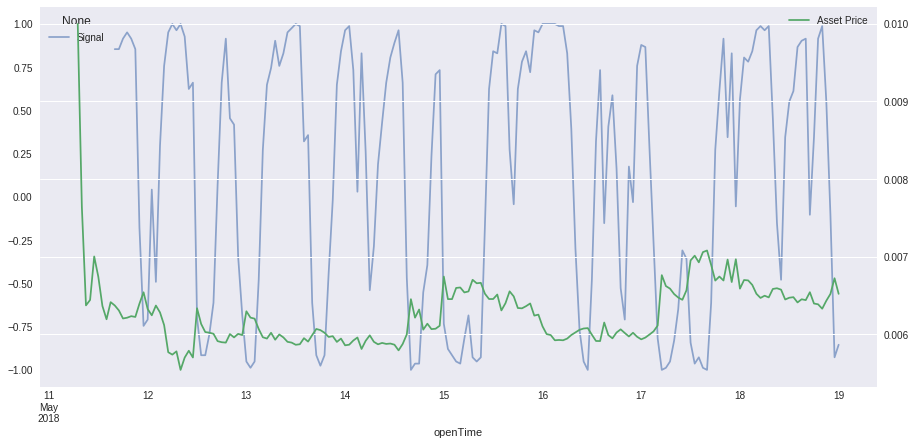

In [22]:
# Ploteo para ver q tenga logica
(scores).plot(figsize=(15,7), alpha=0.6);
plt.legend(['Signal'], bbox_to_anchor=(1, 0.9))
df['close'].plot(secondary_y=True, alpha=1)
plt.legend(['Asset Price'], bbox_to_anchor=(1, 1))
plt.show()
plt.savefig("signal.png")

Una vez que esto esta armado tenemos que ver como poner la orden. Este caso es muy simple compra si el coeficiente es mayor a 0.7 y vende si es menor a 0.7.

Idealmente en el futuro deberia comprar si la tendencia ya se confirma que es alcista o bajista. Osea si, sube a 0.7 sigue subiendo a 1 luego cae de nuevo a 0.7 recien en ese nuevo cruce hara la compra pq es lo que define que se marca la tendencia. En el caso de la venta es al reves, tiene que vender a la primer pasada de que vamos para el -0.7 y no al reves, de esa forma nos vamos a cubrir de los picos

In [28]:
#registro ordenes de compra

buyed = False
df_filtrado = df.dropna()
buy_price= pd.Series(index=df_filtrado.index)
sell_price= pd.Series(index=df_filtrado.index)
treshold= 0.7

for i in df_filtrado.index:        
    if (df_filtrado['score'][i]>=treshold):
        if(buyed==False):
            buy_price[i] = df_filtrado['close'][i]
            buyed = True
    elif (df_filtrado['score'][i]<=treshold):
        if (buyed==True): 
            sell_price[i] = df_filtrado['close'][i]
            buyed=False
            
buy_price = buy_price.dropna()
sell_price= sell_price.dropna()

buy_price = buy_price.to_frame()
sell_price = sell_price.to_frame()

buy_price['orden']="comprar"
sell_price['orden']='vender'

frames = [buy_price,sell_price]
profit = pd.concat(frames)
profit.rename( columns={ 0 : "precio"},inplace=True)


profit.sort_index(inplace=True)
print(profit)
#profit.to_excel('profit_REPBTC.xlsx')

                       precio    orden
openTime                              
2018-05-11 16:00:00  0.006369  comprar
2018-05-11 22:00:00  0.006392   vender
2018-05-12 04:00:00  0.006116  comprar
2018-05-12 10:00:00  0.005785   vender
2018-05-12 19:00:00  0.005890  comprar
2018-05-12 20:00:00  0.006000   vender
2018-05-13 06:00:00  0.006017  comprar
2018-05-13 14:00:00  0.005947   vender
2018-05-13 23:00:00  0.005942  comprar
2018-05-14 03:00:00  0.005956   vender
2018-05-14 04:00:00  0.005808  comprar
2018-05-14 05:00:00  0.005913   vender
2018-05-14 11:00:00  0.005878  comprar
2018-05-14 14:00:00  0.005872   vender
2018-05-14 22:00:00  0.006069  comprar
2018-05-15 00:00:00  0.006742   vender
2018-05-15 12:00:00  0.006452  comprar
2018-05-15 16:00:00  0.006551   vender
2018-05-15 19:00:00  0.006332  comprar
2018-05-16 07:00:00  0.005988   vender
2018-05-16 14:00:00  0.005910  comprar
2018-05-16 15:00:00  0.006149   vender
2018-05-16 23:00:00  0.005965  comprar
2018-05-17 02:00:00  0.00

Finalmente deberiamos sumar una funcion que pueda captar bien el profit que genera esto, deando los valores que en este caso hardcodeamos (el treshold de venta y compra del score y las medias moviles) y que luego busque los valores que optimizan esto. 

Todo junto con como se  deberia sumar a una funcion.  

In [0]:


#Paquetes a importar en Python. 
from  statsmodels import regression
import statsmodels.api as sm
import scipy.stats as stats
import scipy.spatial.distance as distance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#apertura de excels con informacion, esto tiene los
#tickers, ellos deberian armarselo con los trades. 
df=pd.read_excel('REPBTC_binance.xlsx')
df['openTime'] = df['openTime'].map(lambda x: x.replace('T', ' ').rstrip("Z"))
df["openTime"] = pd.to_datetime(df["openTime"])
df.set_index('openTime',inplace=True)

# Calculo de la media movil general, no es tan necesario
df['mu'] = [df['close'][:i].mean() for i in range(len(df))]

#rolling_means ribbon, crear el diccionario.
df['close'].plot(alpha = 1)
rolling_means = {}

# calcular la media movil en diferentes rangos con el precio close 
for i in np.linspace(1, 10, 10):
    X = df['close'].rolling(window=int(i),center=False).mean()
    rolling_means[i] = X
    X.plot(figsize=(15,7), alpha = 0.55)
    
rolling_means = pd.DataFrame(rolling_means).dropna()
plt.show()
plt.savefig("price_ribbon.png")

#crear el score de spearman
scores = pd.Series(index=df['close'].index)
for i in rolling_means.index:
    mavg_values = rolling_means.loc[i]
    # se aplica la funcion de rankdata de scipy
    ranking = stats.rankdata(mavg_values.values)
    # aplicar la formula de ranking de spearman
    d,p = stats.spearmanr(ranking,range(len(ranking)))
    scores[i] = d

    
df['score'] = scores
df.to_excel('momemtum_strat.xlsx')

# Ploteo
(scores).plot(figsize=(15,7), alpha=0.6);
plt.legend(['Signal'], bbox_to_anchor=(1, 0.9))
df['close'].plot(secondary_y=True, alpha=1)
plt.legend(['Asset Price'], bbox_to_anchor=(1, 1))
plt.show()
plt.savefig("signal.png")

#registro ordenes de compra

buyed = False
df_filtrado = df.dropna()
buy_price= pd.Series(index=df_filtrado.index)
sell_price= pd.Series(index=df_filtrado.index)
treshold= 0.7

for i in df_filtrado.index:        
    if (df_filtrado['score'][i]>=treshold):
        if(buyed==False):
            buy_price[i] = df_filtrado['close'][i]
            buyed = True
    elif (df_filtrado['score'][i]<=treshold):
        if (buyed==True): 
            sell_price[i] = df_filtrado['close'][i]
            buyed=False
            
buy_price = buy_price.dropna()
sell_price= sell_price.dropna()

buy_price = buy_price.to_frame()
sell_price = sell_price.to_frame()

buy_price['orden']="comprar"
sell_price['orden']='vender'

frames = [buy_price,sell_price]
profit = pd.concat(frames)
profit.rename( columns={ 0 : "precio"},inplace=True)


profit.sort_index(inplace=True)
print(profit)
profit.to_excel('profit_REPBTC.xlsx')
